Necessary Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'cnn')))
from cnn import CNN
from multilabel_cnn import MultiLabelCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Implement a function load mnist data() that extracts images from the
dataset folders and organizes them into separate lists for images and labels
corresponding to the train, validation, and test splits. Ensure that the
images are loaded from their respective folders without any overlap or
mixing.

In [2]:
def load_mnist_data(base_path='../../data/external/double_mnist', use_label_count=False):
    images = {
        'train': [],
        'val': [],
        'test': []
    }
    labels = {
        'train': [],
        'val': [],
        'test': []
    }

    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(base_path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    img = Image.open(img_path).convert('L')
                    img_array = np.array(img)
                    images[split].append(img_array)

                    if use_label_count:
                        if label == "0":
                            label_count = 0
                        else:
                            label_count = len(label)
                        labels[split].append(label_count)
                    else:
                        labels[split].append(one_hot_encode_label(label))

    return images, labels

images, labels = load_mnist_data(use_label_count=True)


Create a class called MultiMNISTDataset that will be used to create
dataloaders for training and evaluation purposes.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        img = torch.tensor(img, dtype=torch.float32) / 255.0  

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.ToPILImage(),         
    transforms.Resize((28, 28)),     
    transforms.ToTensor(),         
])

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Implement the CNN Class

In [ ]:
model = CNN(task='regression', num_classes=4, num_conv_layers=3,dropout_rate=0.2, optimizer_choice='adam', device=device).to(device)
model.fit(train_loader, val_loader, epochs=5, lr=0.001)

./figures/cnn_loss_plots/plot.png


Training Epoch 1/5:  30%|███       | 119/394 [00:03<00:09, 30.32it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, test_loader, output_file='predictions.csv'):
    model.eval()
    predictions = model.predict(test_loader)
    
    true_labels = []
    for _, labels in test_loader:
        true_labels.append(labels)
    true_labels = torch.cat(true_labels).cpu()
    predictions = torch.round(predictions).cpu()
    
    # Create a DataFrame to display true labels, predictions, and correctness
    results_df = pd.DataFrame({
        'True Labels': true_labels.numpy(),
        'Predictions': predictions.numpy(),
        'Correctness': ['✓' if true == pred else 'x' for true, pred in zip(true_labels.numpy(), predictions.numpy())]
    })
    
    print(results_df.head())
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

accuracy = calculate_accuracy(model, test_loader)


   True Labels  Predictions Correctness
0            3          3.0           ✓
1            3          3.0           ✓
2            3          3.0           ✓
3            3          3.0           ✓
4            3          3.0           ✓
Results saved to predictions.csv
Test Accuracy: 1.0000


In [ ]:
import os
import json
import torch.nn as nn
import torch

hyperparam_combinations = [
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'tanh'},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'tanh'},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.0005, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'sgd', 'activation_function': 'tanh'},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'relu'}
]



plot_save_dir = "./figures/cnn_loss_plots"
os.makedirs(plot_save_dir, exist_ok=True)

best_classification_model, best_classification_loss, best_classification_combination = None, float('inf'), None
best_regression_model, best_regression_loss, best_regression_combination = None, float('inf'), None

for task in ['classification', 'regression']:
    for idx, params in enumerate(hyperparam_combinations, 1):
        loss_figure_save_path = os.path.join(
            plot_save_dir,
            f"{task}_loss_combination_{idx}_lr_{params['lr']}_dropout_{params['dropout_rate']}_layers_{params['num_conv_layers']}_activ_{params['activation_function']}_opt_{params['optimizer_choice']}.png"
        )
        model = CNN(
            task=task,
            num_classes=4 if task == 'classification' else 1,
            num_conv_layers=params['num_conv_layers'],
            dropout_rate=params['dropout_rate'],
            optimizer_choice=params['optimizer_choice'],
            activation_function=['activation_function'],
            device=device,
            loss_figure_save_path = loss_figure_save_path
        )

        model.fit(train_loader, val_loader, epochs=10, lr=params['lr'])
        
        criterion = nn.CrossEntropyLoss() if task == 'classification' else nn.MSELoss()
        val_loss = model.evaluate(val_loader, criterion=criterion)
        
        if task == 'classification':
            if val_loss < best_classification_loss:
                best_classification_model = model
                best_classification_loss = val_loss
                best_classification_combination = params
        else:  # task == 'regression'
            if val_loss < best_regression_loss:
                best_regression_model = model
                best_regression_loss = val_loss
                best_regression_combination = params

best_params = {
    "best_classification_combination": best_classification_combination,
    "best_regression_combination": best_regression_combination
}

params_file_path = os.path.join(plot_save_dir, "best_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best Classification Model Combination:", best_classification_combination)
print("Best Regression Model Combination:", best_regression_combination)
print(f"Best parameters saved to {params_file_path}")

./figures/cnn_loss_plots/classification_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/10:   0%|          | 0/394 [00:00<?, ?it/s]

Training Epoch 1/10: 100%|██████████| 394/394 [00:08<00:00, 43.99it/s]


Epoch [1/10], Training Loss: 0.2405, Validation Loss: 0.0108


Training Epoch 2/10: 100%|██████████| 394/394 [00:07<00:00, 50.15it/s]


Epoch [2/10], Training Loss: 0.0140, Validation Loss: 0.0090


Training Epoch 3/10: 100%|██████████| 394/394 [00:08<00:00, 46.71it/s]


Epoch [3/10], Training Loss: 0.0054, Validation Loss: 0.0059


Training Epoch 4/10: 100%|██████████| 394/394 [00:08<00:00, 48.27it/s]


Epoch [4/10], Training Loss: 0.0037, Validation Loss: 0.0006


Training Epoch 5/10: 100%|██████████| 394/394 [00:08<00:00, 49.05it/s]


Epoch [5/10], Training Loss: 0.0019, Validation Loss: 0.0013


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 46.05it/s]


Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0007


Training Epoch 7/10: 100%|██████████| 394/394 [00:08<00:00, 44.52it/s]


Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0011


Training Epoch 8/10: 100%|██████████| 394/394 [00:09<00:00, 43.18it/s]


Epoch [8/10], Training Loss: 0.0416, Validation Loss: 0.0089


Training Epoch 9/10: 100%|██████████| 394/394 [00:09<00:00, 42.23it/s]


Epoch [9/10], Training Loss: 0.0032, Validation Loss: 0.0015


Training Epoch 10/10: 100%|██████████| 394/394 [00:08<00:00, 45.03it/s]


Epoch [10/10], Training Loss: 0.0016, Validation Loss: 0.0008
./figures/cnn_loss_plots/classification_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:08<00:00, 44.26it/s]


Epoch [1/10], Training Loss: 0.2022, Validation Loss: 0.0114


Training Epoch 2/10: 100%|██████████| 394/394 [00:08<00:00, 46.80it/s]


Epoch [2/10], Training Loss: 0.0110, Validation Loss: 0.0035


Training Epoch 3/10: 100%|██████████| 394/394 [00:10<00:00, 38.83it/s]


Epoch [3/10], Training Loss: 0.0150, Validation Loss: 0.0020


Training Epoch 4/10: 100%|██████████| 394/394 [00:08<00:00, 46.46it/s]


Epoch [4/10], Training Loss: 0.0038, Validation Loss: 0.0005


Training Epoch 5/10: 100%|██████████| 394/394 [00:08<00:00, 46.77it/s]


Epoch [5/10], Training Loss: 0.0015, Validation Loss: 0.0002


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 47.52it/s]


Epoch [6/10], Training Loss: 0.0085, Validation Loss: 0.0028


Training Epoch 7/10: 100%|██████████| 394/394 [00:09<00:00, 43.76it/s]


Epoch [7/10], Training Loss: 0.0072, Validation Loss: 0.0012


Training Epoch 8/10: 100%|██████████| 394/394 [00:08<00:00, 45.88it/s]


Epoch [8/10], Training Loss: 0.0034, Validation Loss: 0.0004


Training Epoch 9/10: 100%|██████████| 394/394 [00:06<00:00, 60.05it/s]


Epoch [9/10], Training Loss: 0.0016, Validation Loss: 0.0002


Training Epoch 10/10: 100%|██████████| 394/394 [00:08<00:00, 44.05it/s]


Epoch [10/10], Training Loss: 0.0013, Validation Loss: 0.0007
./figures/cnn_loss_plots/classification_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:10<00:00, 36.24it/s]


Epoch [1/10], Training Loss: 0.2735, Validation Loss: 0.0162


Training Epoch 2/10: 100%|██████████| 394/394 [00:09<00:00, 40.77it/s]


Epoch [2/10], Training Loss: 0.0052, Validation Loss: 0.0020


Training Epoch 3/10: 100%|██████████| 394/394 [00:11<00:00, 34.49it/s]


Epoch [3/10], Training Loss: 0.0055, Validation Loss: 0.0004


Training Epoch 4/10: 100%|██████████| 394/394 [00:11<00:00, 34.94it/s]


Epoch [4/10], Training Loss: 0.0005, Validation Loss: 0.0006


Training Epoch 5/10: 100%|██████████| 394/394 [00:11<00:00, 34.76it/s]


Epoch [5/10], Training Loss: 0.0159, Validation Loss: 0.0042


Training Epoch 6/10: 100%|██████████| 394/394 [00:11<00:00, 34.93it/s]


Epoch [6/10], Training Loss: 0.0059, Validation Loss: 0.0007


Training Epoch 7/10: 100%|██████████| 394/394 [00:12<00:00, 31.44it/s]


Epoch [7/10], Training Loss: 0.0019, Validation Loss: 0.0002


Training Epoch 8/10: 100%|██████████| 394/394 [00:12<00:00, 31.59it/s]


Epoch [8/10], Training Loss: 0.0001, Validation Loss: 0.0000


Training Epoch 9/10: 100%|██████████| 394/394 [00:09<00:00, 39.96it/s]


Epoch [9/10], Training Loss: 0.0001, Validation Loss: 0.0027


Training Epoch 10/10: 100%|██████████| 394/394 [00:13<00:00, 30.25it/s]


Epoch [10/10], Training Loss: 0.0001, Validation Loss: 0.0000
./figures/cnn_loss_plots/classification_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:10<00:00, 38.34it/s]


Epoch [1/10], Training Loss: 1.1824, Validation Loss: 1.0914


Training Epoch 2/10: 100%|██████████| 394/394 [00:09<00:00, 39.87it/s]


Epoch [2/10], Training Loss: 1.1311, Validation Loss: 1.0798


Training Epoch 3/10: 100%|██████████| 394/394 [00:08<00:00, 44.42it/s]


Epoch [3/10], Training Loss: 1.1117, Validation Loss: 1.0421


Training Epoch 4/10: 100%|██████████| 394/394 [00:07<00:00, 52.23it/s]


Epoch [4/10], Training Loss: 1.0141, Validation Loss: 0.8346


Training Epoch 5/10: 100%|██████████| 394/394 [00:09<00:00, 42.11it/s]


Epoch [5/10], Training Loss: 0.7012, Validation Loss: 0.4103


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 45.86it/s]


Epoch [6/10], Training Loss: 0.2885, Validation Loss: 0.1223


Training Epoch 7/10: 100%|██████████| 394/394 [00:11<00:00, 33.10it/s]


Epoch [7/10], Training Loss: 0.1629, Validation Loss: 0.0863


Training Epoch 8/10: 100%|██████████| 394/394 [00:09<00:00, 43.32it/s]


Epoch [8/10], Training Loss: 0.1204, Validation Loss: 0.0536


Training Epoch 9/10: 100%|██████████| 394/394 [00:08<00:00, 48.61it/s]


Epoch [9/10], Training Loss: 0.0950, Validation Loss: 0.0476


Training Epoch 10/10: 100%|██████████| 394/394 [00:10<00:00, 36.83it/s]


Epoch [10/10], Training Loss: 0.0730, Validation Loss: 0.0242
./figures/cnn_loss_plots/classification_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:08<00:00, 45.26it/s]


Epoch [1/10], Training Loss: 0.3230, Validation Loss: 0.0445


Training Epoch 2/10: 100%|██████████| 394/394 [00:10<00:00, 36.69it/s]


Epoch [2/10], Training Loss: 0.0353, Validation Loss: 0.0100


Training Epoch 3/10: 100%|██████████| 394/394 [00:17<00:00, 22.23it/s]


Epoch [3/10], Training Loss: 0.0090, Validation Loss: 0.0056


Training Epoch 4/10: 100%|██████████| 394/394 [00:10<00:00, 36.87it/s]


Epoch [4/10], Training Loss: 0.0081, Validation Loss: 0.0059


Training Epoch 5/10: 100%|██████████| 394/394 [00:13<00:00, 29.30it/s]


Epoch [5/10], Training Loss: 0.0036, Validation Loss: 0.0035


Training Epoch 6/10: 100%|██████████| 394/394 [00:09<00:00, 42.81it/s]


Epoch [6/10], Training Loss: 0.0024, Validation Loss: 0.0052


Training Epoch 7/10: 100%|██████████| 394/394 [00:08<00:00, 44.29it/s]


Epoch [7/10], Training Loss: 0.0028, Validation Loss: 0.0011


Training Epoch 8/10: 100%|██████████| 394/394 [00:08<00:00, 46.66it/s]


Epoch [8/10], Training Loss: 0.0010, Validation Loss: 0.0009


Training Epoch 9/10: 100%|██████████| 394/394 [00:07<00:00, 51.05it/s]


Epoch [9/10], Training Loss: 0.0011, Validation Loss: 0.0010


Training Epoch 10/10: 100%|██████████| 394/394 [00:08<00:00, 44.79it/s]


Epoch [10/10], Training Loss: 0.0064, Validation Loss: 0.0055
./figures/cnn_loss_plots/classification_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:09<00:00, 42.03it/s]


Epoch [1/10], Training Loss: 1.1790, Validation Loss: 1.0853


Training Epoch 2/10: 100%|██████████| 394/394 [00:11<00:00, 33.56it/s]


Epoch [2/10], Training Loss: 1.1198, Validation Loss: 1.0543


Training Epoch 3/10: 100%|██████████| 394/394 [00:09<00:00, 43.21it/s]


Epoch [3/10], Training Loss: 1.0657, Validation Loss: 0.9591


Training Epoch 4/10: 100%|██████████| 394/394 [00:09<00:00, 40.18it/s]


Epoch [4/10], Training Loss: 0.8748, Validation Loss: 0.6448


Training Epoch 5/10: 100%|██████████| 394/394 [00:10<00:00, 39.25it/s]


Epoch [5/10], Training Loss: 0.5767, Validation Loss: 0.3791


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 48.92it/s]


Epoch [6/10], Training Loss: 0.3992, Validation Loss: 0.2481


Training Epoch 7/10: 100%|██████████| 394/394 [00:07<00:00, 51.35it/s]


Epoch [7/10], Training Loss: 0.3060, Validation Loss: 0.1776


Training Epoch 8/10: 100%|██████████| 394/394 [00:08<00:00, 45.24it/s]


Epoch [8/10], Training Loss: 0.2462, Validation Loss: 0.1648


Training Epoch 9/10: 100%|██████████| 394/394 [00:08<00:00, 48.03it/s]


Epoch [9/10], Training Loss: 0.2110, Validation Loss: 0.1374


Training Epoch 10/10: 100%|██████████| 394/394 [00:09<00:00, 40.87it/s]


Epoch [10/10], Training Loss: 0.1829, Validation Loss: 0.1016
./figures/cnn_loss_plots/classification_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:11<00:00, 34.04it/s]


Epoch [1/10], Training Loss: 0.3608, Validation Loss: 0.0184


Training Epoch 2/10: 100%|██████████| 394/394 [00:10<00:00, 37.11it/s]


Epoch [2/10], Training Loss: 0.0276, Validation Loss: 0.0032


Training Epoch 3/10: 100%|██████████| 394/394 [03:36<00:00,  1.82it/s]


Epoch [3/10], Training Loss: 0.0046, Validation Loss: 0.0013


Training Epoch 4/10: 100%|██████████| 394/394 [00:26<00:00, 14.70it/s]


Epoch [4/10], Training Loss: 0.0021, Validation Loss: 0.0004


Training Epoch 5/10: 100%|██████████| 394/394 [00:13<00:00, 28.77it/s]


Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0002


Training Epoch 6/10: 100%|██████████| 394/394 [00:13<00:00, 30.06it/s]


Epoch [6/10], Training Loss: 0.0036, Validation Loss: 0.0004


Training Epoch 7/10: 100%|██████████| 394/394 [00:14<00:00, 27.96it/s]


Epoch [7/10], Training Loss: 0.0007, Validation Loss: 0.0001


Training Epoch 8/10: 100%|██████████| 394/394 [00:12<00:00, 30.34it/s]


Epoch [8/10], Training Loss: 0.0256, Validation Loss: 0.0054


Training Epoch 9/10: 100%|██████████| 394/394 [00:12<00:00, 32.62it/s]


Epoch [9/10], Training Loss: 0.0022, Validation Loss: 0.0002


Training Epoch 10/10: 100%|██████████| 394/394 [00:11<00:00, 33.75it/s]


Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0001
./figures/cnn_loss_plots/classification_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:10<00:00, 36.31it/s]


Epoch [1/10], Training Loss: 1.1796, Validation Loss: 1.0878


Training Epoch 2/10: 100%|██████████| 394/394 [00:10<00:00, 37.50it/s]


Epoch [2/10], Training Loss: 1.1210, Validation Loss: 1.0561


Training Epoch 3/10: 100%|██████████| 394/394 [00:09<00:00, 39.76it/s]


Epoch [3/10], Training Loss: 1.0593, Validation Loss: 0.9180


Training Epoch 4/10: 100%|██████████| 394/394 [00:10<00:00, 36.23it/s]


Epoch [4/10], Training Loss: 0.8479, Validation Loss: 0.6107


Training Epoch 5/10: 100%|██████████| 394/394 [00:36<00:00, 10.85it/s]


Epoch [5/10], Training Loss: 0.4496, Validation Loss: 0.1800


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 44.02it/s]


Epoch [6/10], Training Loss: 0.1968, Validation Loss: 0.0809


Training Epoch 7/10: 100%|██████████| 394/394 [00:08<00:00, 44.21it/s]


Epoch [7/10], Training Loss: 0.1314, Validation Loss: 0.0502


Training Epoch 8/10: 100%|██████████| 394/394 [01:30<00:00,  4.34it/s]


Epoch [8/10], Training Loss: 0.0981, Validation Loss: 0.0379


Training Epoch 9/10: 100%|██████████| 394/394 [03:04<00:00,  2.14it/s]


Epoch [9/10], Training Loss: 0.0712, Validation Loss: 0.0501


Training Epoch 10/10: 100%|██████████| 394/394 [00:09<00:00, 40.74it/s]


Epoch [10/10], Training Loss: 0.0557, Validation Loss: 0.0189
./figures/cnn_loss_plots/regression_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:10<00:00, 36.75it/s]


Epoch [1/10], Training Loss: 0.1773, Validation Loss: 0.0228


Training Epoch 2/10: 100%|██████████| 394/394 [00:08<00:00, 45.17it/s]


Epoch [2/10], Training Loss: 0.0410, Validation Loss: 0.0299


Training Epoch 3/10: 100%|██████████| 394/394 [00:10<00:00, 36.93it/s]


Epoch [3/10], Training Loss: 0.0368, Validation Loss: 0.0237


Training Epoch 4/10: 100%|██████████| 394/394 [01:51<00:00,  3.52it/s]


Epoch [4/10], Training Loss: 0.0323, Validation Loss: 0.0096


Training Epoch 5/10: 100%|██████████| 394/394 [02:11<00:00,  2.99it/s]


Epoch [5/10], Training Loss: 0.0327, Validation Loss: 0.0133


Training Epoch 6/10: 100%|██████████| 394/394 [02:09<00:00,  3.04it/s]


Epoch [6/10], Training Loss: 0.0272, Validation Loss: 0.0121


Training Epoch 7/10: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s]


Epoch [7/10], Training Loss: 0.0272, Validation Loss: 0.0201


Training Epoch 8/10: 100%|██████████| 394/394 [02:09<00:00,  3.04it/s]


Epoch [8/10], Training Loss: 0.0246, Validation Loss: 0.0090


Training Epoch 9/10: 100%|██████████| 394/394 [02:02<00:00,  3.22it/s]


Epoch [9/10], Training Loss: 0.0242, Validation Loss: 0.0327


Training Epoch 10/10: 100%|██████████| 394/394 [02:05<00:00,  3.15it/s]


Epoch [10/10], Training Loss: 0.0222, Validation Loss: 0.0050
./figures/cnn_loss_plots/regression_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [02:00<00:00,  3.26it/s]


Epoch [1/10], Training Loss: 0.1758, Validation Loss: 0.0154


Training Epoch 2/10: 100%|██████████| 394/394 [02:06<00:00,  3.11it/s]


Epoch [2/10], Training Loss: 0.0693, Validation Loss: 0.0134


Training Epoch 3/10: 100%|██████████| 394/394 [02:08<00:00,  3.07it/s]


Epoch [3/10], Training Loss: 0.0601, Validation Loss: 0.0151


Training Epoch 4/10: 100%|██████████| 394/394 [02:03<00:00,  3.20it/s]


Epoch [4/10], Training Loss: 0.0588, Validation Loss: 0.0082


Training Epoch 5/10: 100%|██████████| 394/394 [02:03<00:00,  3.19it/s]


Epoch [5/10], Training Loss: 0.0554, Validation Loss: 0.0094


Training Epoch 6/10: 100%|██████████| 394/394 [02:09<00:00,  3.03it/s]


Epoch [6/10], Training Loss: 0.0494, Validation Loss: 0.0089


Training Epoch 7/10: 100%|██████████| 394/394 [01:59<00:00,  3.29it/s]


Epoch [7/10], Training Loss: 0.0480, Validation Loss: 0.0071


Training Epoch 8/10: 100%|██████████| 394/394 [01:18<00:00,  5.02it/s]


Epoch [8/10], Training Loss: 0.0441, Validation Loss: 0.0064


Training Epoch 9/10: 100%|██████████| 394/394 [00:08<00:00, 45.54it/s]


Epoch [9/10], Training Loss: 0.0411, Validation Loss: 0.0087


Training Epoch 10/10: 100%|██████████| 394/394 [00:05<00:00, 71.02it/s]


Epoch [10/10], Training Loss: 0.0394, Validation Loss: 0.0098
./figures/cnn_loss_plots/regression_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:08<00:00, 48.17it/s]


Epoch [1/10], Training Loss: 0.1662, Validation Loss: 0.0231


Training Epoch 2/10: 100%|██████████| 394/394 [00:07<00:00, 49.87it/s]


Epoch [2/10], Training Loss: 0.0418, Validation Loss: 0.0123


Training Epoch 3/10: 100%|██████████| 394/394 [00:07<00:00, 49.32it/s]


Epoch [3/10], Training Loss: 0.0345, Validation Loss: 0.0088


Training Epoch 4/10: 100%|██████████| 394/394 [00:09<00:00, 41.01it/s]


Epoch [4/10], Training Loss: 0.0282, Validation Loss: 0.0110


Training Epoch 5/10: 100%|██████████| 394/394 [00:09<00:00, 41.30it/s]


Epoch [5/10], Training Loss: 0.0300, Validation Loss: 0.0057


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 45.95it/s]


Epoch [6/10], Training Loss: 0.0247, Validation Loss: 0.0081


Training Epoch 7/10: 100%|██████████| 394/394 [00:08<00:00, 46.89it/s]


Epoch [7/10], Training Loss: 0.0244, Validation Loss: 0.0053


Training Epoch 8/10: 100%|██████████| 394/394 [00:08<00:00, 44.24it/s]


Epoch [8/10], Training Loss: 0.0221, Validation Loss: 0.0039


Training Epoch 9/10: 100%|██████████| 394/394 [00:11<00:00, 33.25it/s]


Epoch [9/10], Training Loss: 0.0215, Validation Loss: 0.0220


Training Epoch 10/10: 100%|██████████| 394/394 [00:11<00:00, 34.34it/s]


Epoch [10/10], Training Loss: 0.0203, Validation Loss: 0.0042
./figures/cnn_loss_plots/regression_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:10<00:00, 37.63it/s]


Epoch [1/10], Training Loss: 0.5806, Validation Loss: 0.1793


Training Epoch 2/10: 100%|██████████| 394/394 [00:10<00:00, 38.31it/s]


Epoch [2/10], Training Loss: 0.2146, Validation Loss: 0.1263


Training Epoch 3/10: 100%|██████████| 394/394 [00:10<00:00, 37.33it/s]


Epoch [3/10], Training Loss: 0.1584, Validation Loss: 0.0930


Training Epoch 4/10: 100%|██████████| 394/394 [00:10<00:00, 36.40it/s]


Epoch [4/10], Training Loss: 0.1237, Validation Loss: 0.0746


Training Epoch 5/10: 100%|██████████| 394/394 [00:09<00:00, 39.59it/s]


Epoch [5/10], Training Loss: 0.0969, Validation Loss: 0.0468


Training Epoch 6/10: 100%|██████████| 394/394 [00:09<00:00, 39.47it/s]


Epoch [6/10], Training Loss: 0.0643, Validation Loss: 0.0262


Training Epoch 7/10: 100%|██████████| 394/394 [00:09<00:00, 40.60it/s]


Epoch [7/10], Training Loss: 0.0451, Validation Loss: 0.0177


Training Epoch 8/10: 100%|██████████| 394/394 [00:10<00:00, 38.51it/s]


Epoch [8/10], Training Loss: 0.0377, Validation Loss: 0.0147


Training Epoch 9/10: 100%|██████████| 394/394 [00:10<00:00, 36.11it/s]


Epoch [9/10], Training Loss: 0.0336, Validation Loss: 0.0155


Training Epoch 10/10: 100%|██████████| 394/394 [00:10<00:00, 36.31it/s]


Epoch [10/10], Training Loss: 0.0312, Validation Loss: 0.0116
./figures/cnn_loss_plots/regression_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:09<00:00, 41.24it/s]


Epoch [1/10], Training Loss: 0.1791, Validation Loss: 0.0496


Training Epoch 2/10: 100%|██████████| 394/394 [00:08<00:00, 44.61it/s]


Epoch [2/10], Training Loss: 0.0443, Validation Loss: 0.0459


Training Epoch 3/10: 100%|██████████| 394/394 [00:09<00:00, 40.10it/s]


Epoch [3/10], Training Loss: 0.0324, Validation Loss: 0.0146


Training Epoch 4/10: 100%|██████████| 394/394 [00:08<00:00, 45.36it/s]


Epoch [4/10], Training Loss: 0.0292, Validation Loss: 0.0103


Training Epoch 5/10: 100%|██████████| 394/394 [00:08<00:00, 43.90it/s]


Epoch [5/10], Training Loss: 0.0286, Validation Loss: 0.0107


Training Epoch 6/10: 100%|██████████| 394/394 [00:09<00:00, 43.65it/s]


Epoch [6/10], Training Loss: 0.0247, Validation Loss: 0.0153


Training Epoch 7/10: 100%|██████████| 394/394 [00:08<00:00, 46.80it/s]


Epoch [7/10], Training Loss: 0.0240, Validation Loss: 0.0083


Training Epoch 8/10: 100%|██████████| 394/394 [00:09<00:00, 39.89it/s]


Epoch [8/10], Training Loss: 0.0252, Validation Loss: 0.0122


Training Epoch 9/10: 100%|██████████| 394/394 [00:09<00:00, 40.92it/s]


Epoch [9/10], Training Loss: 0.0236, Validation Loss: 0.0070


Training Epoch 10/10: 100%|██████████| 394/394 [00:07<00:00, 49.73it/s]


Epoch [10/10], Training Loss: 0.0224, Validation Loss: 0.0065
./figures/cnn_loss_plots/regression_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:07<00:00, 53.37it/s]


Epoch [1/10], Training Loss: 0.6339, Validation Loss: 0.2644


Training Epoch 2/10: 100%|██████████| 394/394 [00:07<00:00, 52.70it/s]


Epoch [2/10], Training Loss: 0.2191, Validation Loss: 0.1211


Training Epoch 3/10: 100%|██████████| 394/394 [00:06<00:00, 58.62it/s]


Epoch [3/10], Training Loss: 0.1777, Validation Loss: 0.0986


Training Epoch 4/10: 100%|██████████| 394/394 [00:09<00:00, 43.30it/s]


Epoch [4/10], Training Loss: 0.1627, Validation Loss: 0.0964


Training Epoch 5/10: 100%|██████████| 394/394 [00:05<00:00, 67.46it/s]


Epoch [5/10], Training Loss: 0.1561, Validation Loss: 0.0893


Training Epoch 6/10: 100%|██████████| 394/394 [00:05<00:00, 71.07it/s]


Epoch [6/10], Training Loss: 0.1445, Validation Loss: 0.0859


Training Epoch 7/10: 100%|██████████| 394/394 [00:06<00:00, 63.04it/s]


Epoch [7/10], Training Loss: 0.1357, Validation Loss: 0.0779


Training Epoch 8/10: 100%|██████████| 394/394 [00:05<00:00, 66.27it/s]


Epoch [8/10], Training Loss: 0.1241, Validation Loss: 0.0708


Training Epoch 9/10: 100%|██████████| 394/394 [00:06<00:00, 58.50it/s]


Epoch [9/10], Training Loss: 0.1142, Validation Loss: 0.0673


Training Epoch 10/10: 100%|██████████| 394/394 [00:05<00:00, 73.70it/s]


Epoch [10/10], Training Loss: 0.0987, Validation Loss: 0.0576
./figures/cnn_loss_plots/regression_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:06<00:00, 57.02it/s]


Epoch [1/10], Training Loss: 0.2334, Validation Loss: 0.0235


Training Epoch 2/10: 100%|██████████| 394/394 [00:08<00:00, 47.99it/s]


Epoch [2/10], Training Loss: 0.0421, Validation Loss: 0.0257


Training Epoch 3/10: 100%|██████████| 394/394 [00:07<00:00, 52.48it/s]


Epoch [3/10], Training Loss: 0.0318, Validation Loss: 0.0196


Training Epoch 4/10: 100%|██████████| 394/394 [00:08<00:00, 44.16it/s]


Epoch [4/10], Training Loss: 0.0283, Validation Loss: 0.0261


Training Epoch 5/10: 100%|██████████| 394/394 [00:07<00:00, 51.71it/s]


Epoch [5/10], Training Loss: 0.0277, Validation Loss: 0.0133


Training Epoch 6/10: 100%|██████████| 394/394 [00:08<00:00, 47.06it/s]


Epoch [6/10], Training Loss: 0.0251, Validation Loss: 0.0127


Training Epoch 7/10: 100%|██████████| 394/394 [00:09<00:00, 42.15it/s]


Epoch [7/10], Training Loss: 0.0242, Validation Loss: 0.0099


Training Epoch 8/10: 100%|██████████| 394/394 [00:08<00:00, 44.66it/s]


Epoch [8/10], Training Loss: 0.0236, Validation Loss: 0.0037


Training Epoch 9/10: 100%|██████████| 394/394 [00:08<00:00, 45.07it/s]


Epoch [9/10], Training Loss: 0.0234, Validation Loss: 0.0050


Training Epoch 10/10: 100%|██████████| 394/394 [00:09<00:00, 42.67it/s]


Epoch [10/10], Training Loss: 0.0239, Validation Loss: 0.0106
./figures/cnn_loss_plots/regression_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:08<00:00, 49.03it/s]


Epoch [1/10], Training Loss: 0.6105, Validation Loss: 0.2001


Training Epoch 2/10: 100%|██████████| 394/394 [00:07<00:00, 49.53it/s]


Epoch [2/10], Training Loss: 0.2175, Validation Loss: 0.1246


Training Epoch 3/10: 100%|██████████| 394/394 [00:07<00:00, 51.21it/s]


Epoch [3/10], Training Loss: 0.1628, Validation Loss: 0.0950


Training Epoch 4/10: 100%|██████████| 394/394 [00:12<00:00, 31.68it/s]


Epoch [4/10], Training Loss: 0.1363, Validation Loss: 0.0819


Training Epoch 5/10: 100%|██████████| 394/394 [00:10<00:00, 36.62it/s]


Epoch [5/10], Training Loss: 0.1166, Validation Loss: 0.0623


Training Epoch 6/10: 100%|██████████| 394/394 [00:10<00:00, 36.31it/s]


Epoch [6/10], Training Loss: 0.0891, Validation Loss: 0.0393


Training Epoch 7/10: 100%|██████████| 394/394 [00:10<00:00, 35.86it/s]


Epoch [7/10], Training Loss: 0.0571, Validation Loss: 0.0232


Training Epoch 8/10: 100%|██████████| 394/394 [00:11<00:00, 33.46it/s]


Epoch [8/10], Training Loss: 0.0422, Validation Loss: 0.0174


Training Epoch 9/10: 100%|██████████| 394/394 [00:12<00:00, 32.13it/s]


Epoch [9/10], Training Loss: 0.0342, Validation Loss: 0.0182


Training Epoch 10/10: 100%|██████████| 394/394 [00:10<00:00, 36.15it/s]


Epoch [10/10], Training Loss: 0.0326, Validation Loss: 0.0141
Best Classification Model Combination: {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'}
Best Regression Model Combination: {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'}
Best parameters saved to ./figures/cnn_loss_plots/best_model_params.json


In [19]:
def read_best_params(file_path):
    with open(file_path, 'r') as json_file:
        params = json.load(json_file)
    return params

loaded_params = read_best_params(params_file_path)
print("Loaded Parameters:", loaded_params)


Loaded Parameters: {'best_classification_combination': {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'}, 'best_regression_combination': {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'}}


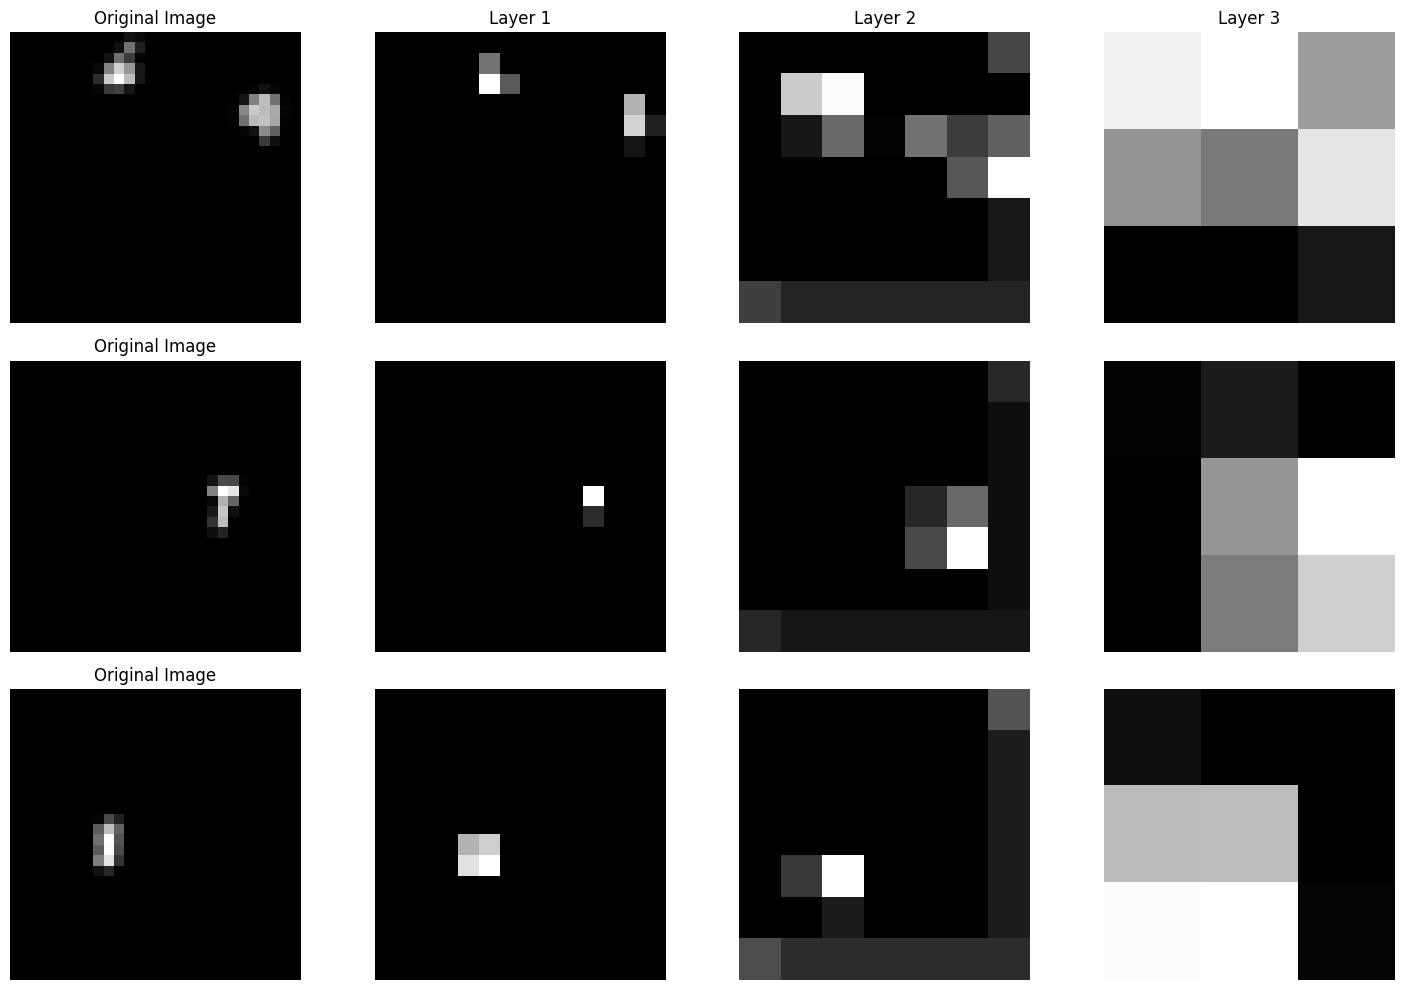

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_feature_maps(model, data_loader, feature_map_index=0, num_images=3):
    model.eval() 

    images, _ = next(iter(data_loader))
    images = images.to(model.device)
    with torch.no_grad():
        _, feature_maps = model(images, return_feature_maps=True)
    selected_images = images[:num_images]
    selected_maps = [feature_maps[i][:num_images] for i in range(len(feature_maps))]

    fig, axes = plt.subplots(num_images, len(selected_maps) + 1, figsize=(15, 10))

    for i in range(num_images):
        axes[i, 0].imshow(selected_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        for j in range(len(selected_maps)):
            axes[i, j + 1].imshow(selected_maps[j][i, feature_map_index].cpu().numpy(), cmap='gray')
            axes[i, j + 1].axis('off')
            if i == 0:
                axes[i, j + 1].set_title(f'Layer {j + 1}')

    plt.tight_layout()
    plt.show()

visualize_feature_maps(model, train_loader, feature_map_index=2)


In [5]:
def one_hot_encode_digit(digit):
    """Creates an 11-dimensional one-hot vector for a single digit or blank."""
    one_hot = np.zeros(11)
    if digit == '*':
        one_hot[10] = 1 
    else:
        one_hot[int(digit)] = 1
    return one_hot

def one_hot_encode_label(label):
    """Encodes the label (up to three digits) as a 33-dimensional vector."""
    label_str = str(label).ljust(3, '*')
    one_hot_encoded = np.concatenate([one_hot_encode_digit(digit) for digit in label_str])
    return one_hot_encoded

In [6]:
images, labels = load_mnist_data(use_label_count=False)

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(num_conv_layers=3,dropout_rate=0.25).to(device)

model.fit(train_loader, val_loader, epochs=30, lr=0.001)

Training Epoch 1/30: 100%|██████████| 394/394 [00:10<00:00, 36.52it/s]


Epoch [1/30], Training Loss: 4.9327
Epoch [1/30], Validation Loss: 5.3432


Training Epoch 2/30: 100%|██████████| 394/394 [00:09<00:00, 41.58it/s]


Epoch [2/30], Training Loss: 4.2289
Epoch [2/30], Validation Loss: 4.7570


Training Epoch 3/30: 100%|██████████| 394/394 [00:10<00:00, 37.34it/s]


Epoch [3/30], Training Loss: 3.7475
Epoch [3/30], Validation Loss: 4.5684


Training Epoch 4/30: 100%|██████████| 394/394 [00:11<00:00, 34.98it/s]


Epoch [4/30], Training Loss: 3.3397
Epoch [4/30], Validation Loss: 4.1200


Training Epoch 5/30: 100%|██████████| 394/394 [00:10<00:00, 37.30it/s]


Epoch [5/30], Training Loss: 3.0723
Epoch [5/30], Validation Loss: 4.2165


Training Epoch 6/30: 100%|██████████| 394/394 [00:11<00:00, 33.05it/s]


Epoch [6/30], Training Loss: 2.8737
Epoch [6/30], Validation Loss: 3.9674


Training Epoch 7/30: 100%|██████████| 394/394 [00:11<00:00, 35.68it/s]


Epoch [7/30], Training Loss: 2.5440
Epoch [7/30], Validation Loss: 3.5737


Training Epoch 8/30: 100%|██████████| 394/394 [00:10<00:00, 36.45it/s]


Epoch [8/30], Training Loss: 2.2712
Epoch [8/30], Validation Loss: 3.7857


Training Epoch 9/30: 100%|██████████| 394/394 [00:10<00:00, 36.65it/s]


Epoch [9/30], Training Loss: 2.0743
Epoch [9/30], Validation Loss: 3.3612


Training Epoch 10/30: 100%|██████████| 394/394 [00:11<00:00, 33.00it/s]


Epoch [10/30], Training Loss: 1.8976
Epoch [10/30], Validation Loss: 3.4899


Training Epoch 11/30: 100%|██████████| 394/394 [00:12<00:00, 31.36it/s]


Epoch [11/30], Training Loss: 1.7605
Epoch [11/30], Validation Loss: 3.2437


Training Epoch 12/30: 100%|██████████| 394/394 [00:11<00:00, 33.56it/s]


Epoch [12/30], Training Loss: 1.6080
Epoch [12/30], Validation Loss: 2.8491


Training Epoch 13/30: 100%|██████████| 394/394 [00:10<00:00, 37.27it/s]


Epoch [13/30], Training Loss: 1.4991
Epoch [13/30], Validation Loss: 3.0675


Training Epoch 14/30: 100%|██████████| 394/394 [00:11<00:00, 33.89it/s]


Epoch [14/30], Training Loss: 1.3841
Epoch [14/30], Validation Loss: 3.2548


Training Epoch 15/30: 100%|██████████| 394/394 [00:11<00:00, 33.60it/s]


Epoch [15/30], Training Loss: 1.2925
Epoch [15/30], Validation Loss: 3.0751


Training Epoch 16/30: 100%|██████████| 394/394 [00:11<00:00, 34.39it/s]


Epoch [16/30], Training Loss: 1.2117
Epoch [16/30], Validation Loss: 3.1065


Training Epoch 17/30: 100%|██████████| 394/394 [00:13<00:00, 29.87it/s]


Epoch [17/30], Training Loss: 1.1268
Epoch [17/30], Validation Loss: 3.1110


Training Epoch 18/30: 100%|██████████| 394/394 [00:11<00:00, 34.53it/s]


Epoch [18/30], Training Loss: 1.0686
Epoch [18/30], Validation Loss: 2.9585


Training Epoch 19/30: 100%|██████████| 394/394 [00:11<00:00, 32.90it/s]


Epoch [19/30], Training Loss: 0.9791
Epoch [19/30], Validation Loss: 2.8761


Training Epoch 20/30: 100%|██████████| 394/394 [00:12<00:00, 31.71it/s]


Epoch [20/30], Training Loss: 0.9089
Epoch [20/30], Validation Loss: 3.3850


Training Epoch 21/30: 100%|██████████| 394/394 [00:24<00:00, 15.97it/s]


Epoch [21/30], Training Loss: 0.8828
Epoch [21/30], Validation Loss: 3.0190


Training Epoch 22/30: 100%|██████████| 394/394 [00:19<00:00, 20.51it/s]


Epoch [22/30], Training Loss: 0.8100
Epoch [22/30], Validation Loss: 3.5362


Training Epoch 23/30: 100%|██████████| 394/394 [00:17<00:00, 21.98it/s]


Epoch [23/30], Training Loss: 0.7794
Epoch [23/30], Validation Loss: 3.3036


Training Epoch 24/30: 100%|██████████| 394/394 [00:19<00:00, 20.63it/s]


Epoch [24/30], Training Loss: 0.7429
Epoch [24/30], Validation Loss: 3.1594


Training Epoch 25/30: 100%|██████████| 394/394 [00:16<00:00, 24.58it/s]


Epoch [25/30], Training Loss: 0.6883
Epoch [25/30], Validation Loss: 3.3565


Training Epoch 26/30: 100%|██████████| 394/394 [00:17<00:00, 21.92it/s]


Epoch [26/30], Training Loss: 0.6355
Epoch [26/30], Validation Loss: 3.3527


Training Epoch 27/30: 100%|██████████| 394/394 [00:19<00:00, 20.59it/s]


Epoch [27/30], Training Loss: 0.6196
Epoch [27/30], Validation Loss: 3.5873


Training Epoch 28/30: 100%|██████████| 394/394 [00:20<00:00, 19.02it/s]


Epoch [28/30], Training Loss: 0.5927
Epoch [28/30], Validation Loss: 3.5816


Training Epoch 29/30: 100%|██████████| 394/394 [00:19<00:00, 19.84it/s]


Epoch [29/30], Training Loss: 0.5395
Epoch [29/30], Validation Loss: 3.6758


Training Epoch 30/30: 100%|██████████| 394/394 [00:21<00:00, 18.21it/s]


Epoch [30/30], Training Loss: 0.5333
Epoch [30/30], Validation Loss: 3.6408


In [12]:
def exact_match_accuracy(preds, labels):
    """Calculates the exact match accuracy between predictions and labels."""
    return (preds == labels).all(dim=1).float().mean().item()

def hamming_accuracy(preds, labels):
    """Calculates the Hamming accuracy for multi-label predictions."""
    return (preds == labels).float().mean().item()


def evaluate_model(model, test_loader):
    preds = model.predict(test_loader)
    labels = torch.cat([labels for _, labels in test_loader])
    print(preds[12], labels[12])

    exact_acc = exact_match_accuracy(preds, labels)
    hamming_acc = hamming_accuracy(preds, labels)
    print(f"Exact Match Accuracy: {exact_acc * 100:.2f}%")
    print(f"Hamming Accuracy: {hamming_acc * 100:.2f}%")

evaluate_model(model, test_loader)


tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
Exact Match Accuracy: 32.33%
Hamming Accuracy: 95.55%


In [11]:
hyperparam_combinations = [
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'tanh'},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'tanh'},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.0005, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'sgd', 'activation_function': 'tanh'},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu'},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'relu'}
]

plot_save_dir = "./figures/multilabel_cnn_loss_plots"
os.makedirs(plot_save_dir, exist_ok=True)

best_multi_classification_model, best_multi_classification_loss, best_multi_classification_combination = None, float('inf'), None

for idx, params in enumerate(hyperparam_combinations, 1):
    loss_figure_save_path = os.path.join(
        plot_save_dir,
        f"multilabel_loss_combination_{idx}_lr_{params['lr']}_dropout_{params['dropout_rate']}_layers_{params['num_conv_layers']}_activ_{params['activation_function']}_opt_{params['optimizer_choice']}.png"
    )
    model = MultiLabelCNN(
        num_conv_layers=params['num_conv_layers'],
        dropout_rate=params['dropout_rate'],
        optimizer_choice=params['optimizer_choice'],
        activation_function=params['activation_function'],
        device=device,
        loss_figure_save_path = loss_figure_save_path
    )

    model.fit(train_loader, val_loader, epochs=30, lr=params['lr'])
    
    criterion = nn.CrossEntropyLoss() if task == 'classification' else nn.MSELoss()
    val_loss = model.evaluate(val_loader, criterion=criterion)
    
    
    if val_loss < best_multi_classification_loss:
        best_multi_classification_model = model
        best_multi_classification_loss = val_loss
        best_multi_classification_combination = params

best_params = {
    "best_classification_combination": best_multi_classification_combination
}

params_file_path = os.path.join(plot_save_dir, "best_multilabel_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best Classification Model Combination:", best_classification_combination)
print("Best Regression Model Combination:", best_regression_combination)
print(f"Best parameters saved to {params_file_path}")

Training Epoch 1/30:   7%|▋         | 29/394 [00:00<00:09, 37.57it/s]


KeyboardInterrupt: 